In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from math import sqrt
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
import time

def color(i,j):
    delta=i/j
    return (delta,delta,delta)

def plotImportantFeatures(matrix):
    matrixFeaturesImportances=[] 
    x = []
    n=0
    fig = plt.figure(2)
    for i in matrix :
        matrixFeaturesImportances.append(i.feature_importances_.tolist())
    nbFeatures =  len(matrixFeaturesImportances[0])
    #moyenne d'importance des features pour tous les classifieurs
    mean=[]
    sum=0
    for j in range(0,nbFeatures):
        sum=0
        for classifier in matrixFeaturesImportances :
            sum=sum + classifier[j]
        mean.append(sum/len(matrixFeaturesImportances))   
        
    for i in range(0,len(matrix)):
        e=[]
        for i in range(0,nbFeatures):
            n=n+1/nbFeatures
            e.append(n)
        x.append(e)
    width = 0.125
    plt.subplot(221)
    plt.title('feature importances on every classifier')
    plt.xlabel('features')
    for i in range(0,len(x)):
        colori=color(i%nbFeatures,nbFeatures)
        plt.bar(x[i],matrixFeaturesImportances[i], width, color=colori)
    plt.subplot(222)
    x= range(0,nbFeatures)
    plt.bar(x,mean, 1, color='b')
    plt.title('means of feature importances on every classifier')
    plt.xlabel('features')
    plt.show()
   
def trainClassifier(folderPath,maxTurn):
    classifier=[]
    classifierImportantFeatures=[]
    nbrTurnMax = len(os.listdir(folderPath))
    dataset = np.loadtxt(folderPath+'/turn'+str(1)+'.txt', delimiter=",")
    nbFeatures=len(dataset[0])
    for i in range(0,min(maxTurn,nbrTurnMax-1)):
        dataset = np.loadtxt(folderPath+'/turn'+str(i+1)+'.txt', delimiter=",")
        X = dataset[:,1:]
        y = dataset[:,0]
        model = LogisticRegression()
   
        forest = ExtraTreesClassifier()
        model.fit(X, y)
        forest.fit(X,y)
        classifier.append(model)
        classifierImportantFeatures.append(forest)
  
    plotImportantFeatures(classifierImportantFeatures)
    return classifier

def testClassifier(listClassifier,folderPathTest,maxTurn):

    listTestGame = os.listdir(folderPathTest)
    nbGameTestMax =len(listTestGame)
    resA=[]
    resB=[]
    listClassifier_pred_y=[]
    listClassifier_test_y=[]
    game = np.loadtxt(folderPathTest+'/game'+str(1)+'.txt', delimiter=",")

    for i in range(1,nbGameTestMax+1):
        game = np.loadtxt(folderPathTest+'/game'+str(i)+'.txt', delimiter=",")
        resGameA=[]
        resGameB=[]
        for j in range(0,min(len(game),min(maxTurn,len(listClassifier)))):
            if len(listClassifier_pred_y)<min(len(game),min(maxTurn+1,len(listClassifier))):
                listClassifier_pred_y.append([])
                listClassifier_test_y.append([])
            gameCour=game[:,1:]
            proba = listClassifier[j].predict_proba(gameCour[j].reshape(1, -1))[0][1]
            y = listClassifier[j].predict(gameCour[j].reshape(1, -1))
            listClassifier_pred_y[j].append(y[0])
            listClassifier_test_y[j].append(game[0][0])
            if game[0][0] == 1: #if "Me" won
                resGameA.append(proba)
            else :
                resGameB.append(1-proba)
          
        if len(resGameA)!=0:
            resA.append(resGameA)
        if len(resGameB)!=0:
            resB.append(resGameB)
        
    return resA,resB,listClassifier_pred_y,listClassifier_test_y

def plotProbaMeans(matrixProbaA,matrixProbaB):
    plt.figure(1)
    meanA=[]
    meanB=[]
    matrixALength=len(matrixProbaA)
    matrixBLength=len(matrixProbaB)
    for i in range(0, matrixALength):
        sum=0
        nbGameWithiTurn=0
        for j in matrixProbaA:
             if(len(j)>i):
                sum = sum + j[i]
                nbGameWithiTurn=nbGameWithiTurn+1
        if  nbGameWithiTurn>0:
            meanA.append(sum/ nbGameWithiTurn)
    for i in range(0, matrixBLength):
        sum=0
        nbGameWithiTurn=0
        for j in matrixProbaB:
             
            if(len(j)>i):
                sum = sum + j[i]
                nbGameWithiTurn=nbGameWithiTurn+1
        if  nbGameWithiTurn>0:
            meanB.append(sum/nbGameWithiTurn)
    
    plt.subplot(221)
    plt.plot(meanA)
    plt.ylim(0,1)
    plt.ylabel('mean P of predicted Victory for Me and Me wins')
    plt.xlabel('turns')
    plt.subplot(222)
    plt.plot(meanB)
    plt.ylim(0,1)
    plt.ylabel('mean P of predicted Victory for Opp and Opp wins')
    plt.xlabel('turns')
    plt.show()
    
def plotProba(matrixProbaA,matrixProbaB):
    plt.figure(1)
    for i in range(0,20):
        plt.subplot(221)
        plt.plot(matrixProbaA[i])
    for i in range (0,20):
        plt.subplot(222)
        plt.plot(matrixProbaB[i])
    plt.subplot(221)
    plt.ylim(0,1)
    plt.ylabel('P of predicted Victory for Me and Me wins')
    plt.xlabel('turns')
    plt.subplot(222)
    plt.ylim(0,1)
    plt.ylabel('P of predicted Victory for Opp and Opp wins')
    plt.xlabel('turns')
    plt.show()
      
def printScore(listClassifier_pred_y,listClassifier_test_y):
    for i in range(0,len(listClassifier_pred_y)):
        print('classifier : '+str(i+1))
        print('f1_score : '+str(f1_score(listClassifier_test_y[i],listClassifier_pred_y[i],average='binary')))
        print('MCC :'+str( matthews_corrcoef(listClassifier_test_y[i],listClassifier_pred_y[i]))+'\n')

c:\users\stephen\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\stephen\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\stephen\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\stephen\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:

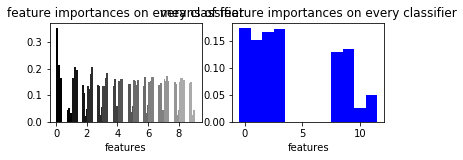

classifier : 1
f1_score : 0.945054945054945
MCC :0.872591176939003

classifier : 2
f1_score : 0.8111111111111112
MCC :0.568505802621676

classifier : 3
f1_score : 0.7885714285714285
MCC :0.5363842300095848

classifier : 4
f1_score : 0.7407407407407408
MCC :0.36945497237035335

classifier : 5
f1_score : 0.7958115183246074
MCC :0.4985406318307865

classifier : 6
f1_score : 0.7422680412371134
MCC :0.3536150681039711

classifier : 7
f1_score : 0.7411167512690355
MCC :0.3392781524656572

classifier : 8
f1_score : 0.6934673366834171
MCC :0.20410038725679272

classifier : 9
f1_score : 0.7128712871287128
MCC :0.2428161811410829



c:\users\stephen\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


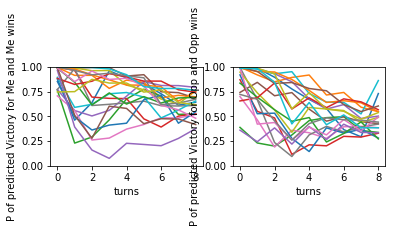

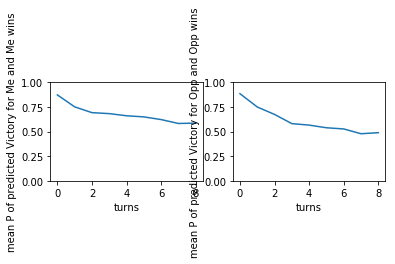

1.1551010608673096


In [3]:
t1 = time.time()
#DataSets 1 tour = 2 players play
nbTurn=9 # nb last turn to be considered

listClassifier=trainClassifier('partiesHS/Datasets_GameOf9Turn/Datasets_train_1turn2plays',nbTurn)
matrixProbaA,matrixProbaB,listClassifier_pred_y,listClassifier_test_y=testClassifier(listClassifier,'partiesHS/Datasets_GameOf9Turn/Datasets_test_1turn2plays',nbTurn)
printScore(listClassifier_pred_y,listClassifier_test_y)
plotProba(matrixProbaA,matrixProbaB)
plotProbaMeans(matrixProbaA,matrixProbaB)

t2 = time.time() - t1
print (t2)

In [4]:
# DataSets 1 turn = 1 player plays
# listClassifier=trainClassifier('partiesHS/Datasets_train')
# matrixProbaA,matrixProbaB,listClassifier_pred_y,listClassifier_test_y=testClassifier(listClassifier,'partiesHS/Datasets_test','partiesHS')
# printScore(listClassifier_pred_y,listClassifier_test_y)
# plotProbaMeans(matrixProbaA,matrixProbaB)